In [ ]:
# segmentation.py
!pip install pydicom
import os
import pydicom
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pydicom
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
#                              DATA LOADING & PREPROCESSING
# -----------------------------------------------------------------------------

def load_dicom_original(dicom_path):
    """Load DICOM file, normalize to [0,1], convert to 3-channel RGB."""
    dicom = pydicom.dcmread(dicom_path)
    image = dicom.pixel_array.astype(np.float32)
    image = (image - image.min()) / (image.max() - image.min() + 1e-8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

def load_mask_original(xml_path, image):
    """
    Build a binary mask from XML bboxes + Otsu thresholding within each box.
    Returns 2D uint8 mask of same H×W as `image`.
    """
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    for bbox in root.findall(".//bndbox"):
        xmin = max(0, int(bbox.find("xmin").text))
        ymin = max(0, int(bbox.find("ymin").text))
        xmax = min(w, int(bbox.find("xmax").text))
        ymax = min(h, int(bbox.find("ymax").text))
        if xmax <= xmin or ymax <= ymin:
            continue

        roi = image[ymin:ymax, xmin:xmax]
        gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
        gray = (gray * 255).astype(np.uint8)
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        _, thr = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        mask[ymin:ymax, xmin:xmax] = thr

    # Clean with opening + dilation
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.dilate(mask, kernel, iterations=2)

    return mask

def map_dicom_to_xml(dicom_dir, xml_dir):
    """
    Walk xml_dir collecting XML filenames by SOPInstanceUID (filename w/o .xml).
    Then walk dicom_dir, read each .dcm, get SOPInstanceUID, and match.
    Returns paired lists of (dicom_path, xml_path).
    """
    uid_to_xml = {}
    for root, _, files in os.walk(xml_dir):
        for fname in files:
            if fname.endswith(".xml"):
                uid = fname[:-4]
                uid_to_xml[uid] = os.path.join(root, fname)

    dicom_paths = []
    xml_paths   = []
    for root, _, files in os.walk(dicom_dir):
        for fname in files:
            if not fname.lower().endswith(".dcm"):
                continue
            path = os.path.join(root, fname)
            ds = pydicom.dcmread(path, stop_before_pixels=True)
            sop = ds.SOPInstanceUID
            if sop in uid_to_xml:
                dicom_paths.append(path)
                xml_paths.append(uid_to_xml[sop])

    return dicom_paths, xml_paths

def prepare_dataset(dicom_dir, xml_dir, img_size=(224,224)):
    """
    Load every .dcm in `dicom_dir`.
    • If there’s a matching XML (by SOPInstanceUID), build the mask from it.
    • Otherwise, give it an all-zero mask (non-nodule).
    Returns:
      X → np.array, shape (N, H, W, 3), dtype float32
      Y → np.array, shape (N, H, W, 1), dtype float32 with values in {0,1}
    """
    # Build a map SOPInstanceUID → xml_path
    uid_to_xml = {}
    for root, _, files in os.walk(xml_dir):
        for fname in files:
            if fname.endswith(".xml"):
                uid = fname[:-4]
                uid_to_xml[uid] = os.path.join(root, fname)

    images, masks = [], []

    # Walk all DICOMs, load image + mask (real or zero)
    for root, _, files in os.walk(dicom_dir):
        for fname in files:
            if not fname.lower().endswith(".dcm"):
                continue
            dcm_path = os.path.join(root, fname)
            # Read header only
            ds = pydicom.dcmread(dcm_path, stop_before_pixels=True)
            sop = ds.SOPInstanceUID

            # Load & normalize image
            img = load_dicom_original(dcm_path)

            # Real mask if xml exists, else zeros
            if sop in uid_to_xml:
                msk = load_mask_original(uid_to_xml[sop], img)
            else:
                msk = np.zeros(img.shape[:2], dtype=np.uint8)

            # Resize both
            img_rs = cv2.resize(img, img_size)
            msk_rs = cv2.resize(msk, img_size, interpolation=cv2.INTER_NEAREST)

            images.append(img_rs)
            # Normalize mask from {0,255} to {0.0,1.0}
            masks.append(msk_rs[..., None].astype(np.float32) / 255.0)

    X = np.array(images, dtype=np.float32)
    Y = np.array(masks,  dtype=np.float32)  # now values are 0.0 or 1.0

    return X, Y


# -----------------------------------------------------------------------------
#                                 MODEL DEFINITION
# -----------------------------------------------------------------------------

def build_vgg19_segnet(input_shape=(224,224,3)):
    """
    VGG19 encoder + SegNet-style decoder.
    Output: single-channel sigmoid mask.
    """
    base = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    s1 = base.get_layer("block1_conv2").output  # 224×224×64
    s2 = base.get_layer("block2_conv2").output  # 112×112×128
    s3 = base.get_layer("block3_conv4").output  # 56×56×256
    s4 = base.get_layer("block4_conv4").output  # 28×28×512
    b  = base.get_layer("block5_conv4").output  # 14×14×512

    # Decoder




    d1 = up_block(b,  s4, 512)
    d2 = up_block(d1, s3, 256)
    d3 = up_block(d2, s2, 128)
    d4 = up_block(d3, s1, 64)

    output = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model  = Model(inputs=base.input, outputs=output)
    return model

# -----------------------------------------------------------------------------
#                                  TRAINING
# -----------------------------------------------------------------------------



In [ ]:
if __name__ == "__main__":
    # Paths
    DICOM_DIR = "D:\\SortedDataset\\nodule"
    XML_DIR   = "D:\\SortedDataset\\Annotation"
    MODEL_DIR = "D:\\SortedDataset\\model"
    os.makedirs(MODEL_DIR, exist_ok=True)

    # 1) Load & split data
    X, Y = prepare_dataset(DICOM_DIR, XML_DIR, img_size=(224,224))
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
    X_val, X_test, Y_val, Y_test     = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

    print("Train:", X_train.shape, Y_train.shape)
    print("Val:  ", X_val.shape,   Y_val.shape)
    print("Test: ", X_test.shape,  Y_test.shape)

    # 2) Oversample nodule-positive slices
    pos_idx = [i for i, m in enumerate(Y_train) if m.sum() > 0]
    neg_idx = [i for i, m in enumerate(Y_train) if m.sum() == 0]
    ratio   = len(neg_idx) // max(1, len(pos_idx))
    extra   = len(neg_idx) % max(1, len(pos_idx))

    X_pos = X_train[pos_idx]
    Y_pos = Y_train[pos_idx]
    X_pos_rep = np.concatenate([X_pos]*ratio + [X_pos[:extra]], axis=0)
    Y_pos_rep = np.concatenate([Y_pos]*ratio + [Y_pos[:extra]], axis=0)

    X_train = np.concatenate([X_train[neg_idx], X_pos_rep], axis=0)
    Y_train = np.concatenate([Y_train[neg_idx], Y_pos_rep], axis=0)
    print(f"After oversampling: {X_train.shape[0]} train slices; positives → {Y_pos_rep.shape[0]}")

    # 3) Build model
    seg_model = build_vgg19_segnet(input_shape=(224,224,3))

    # 4) Define pixel-wise weighted BCE + Dice loss
    total_pix  = np.prod(Y_train.shape[1:]) * len(Y_train)
    pos_pix    = Y_train.sum()
    neg_pix    = total_pix - pos_pix
    pos_weight = float(neg_pix) / (pos_pix + 1e-8)

    def weighted_bce(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        w   = 1 + (pos_weight - 1) * y_true
        return K.mean(bce * w)

    def dice_loss(y_true, y_pred, smooth=1e-6):
        y_t   = K.flatten(y_true)
        y_p   = K.flatten(y_pred)
        inter = K.sum(y_t * y_p)
        return 1 - (2*inter + smooth) / (K.sum(y_t) + K.sum(y_p) + smooth)

    def combined_loss(y_true, y_pred):
        return weighted_bce(y_true, y_pred) + dice_loss(y_true, y_pred)

Train: (1035, 224, 224, 3) (1035, 224, 224, 1)
Val:   (222, 224, 224, 3) (222, 224, 224, 1)
Test:  (222, 224, 224, 3) (222, 224, 224, 1)
After oversampling: 1190 train slices; positives → 595


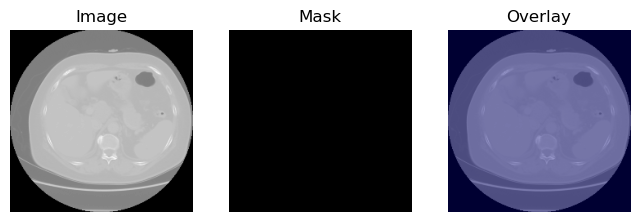

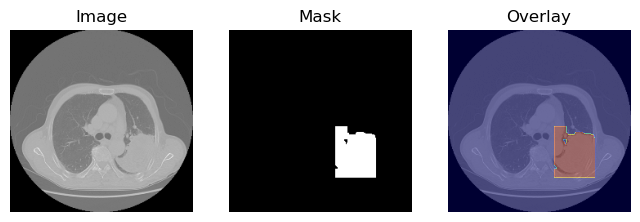

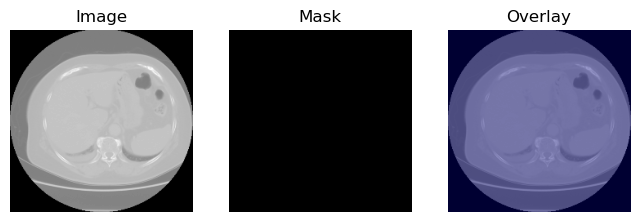

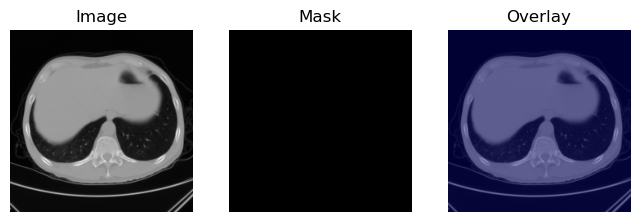

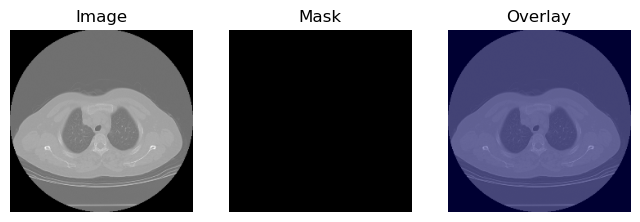

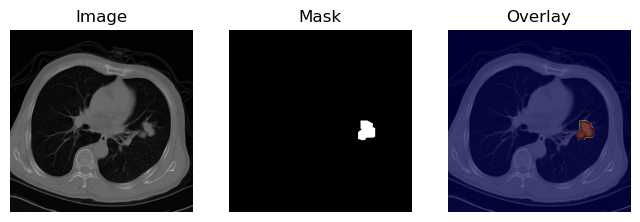

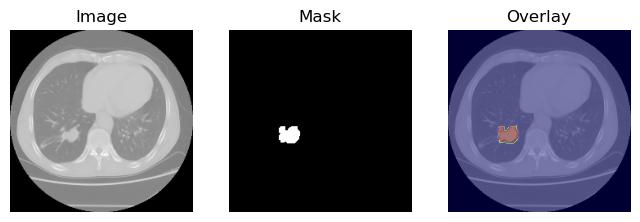

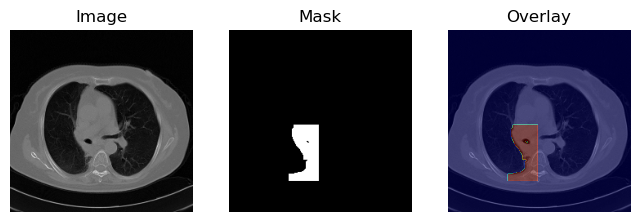

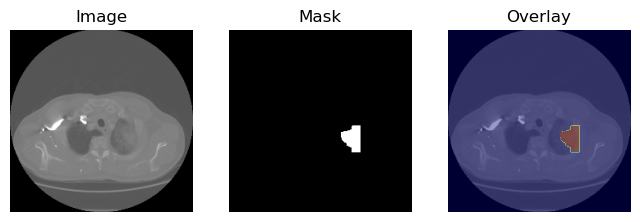

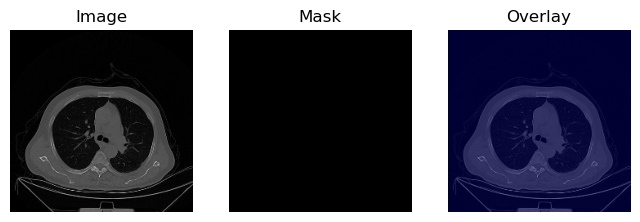

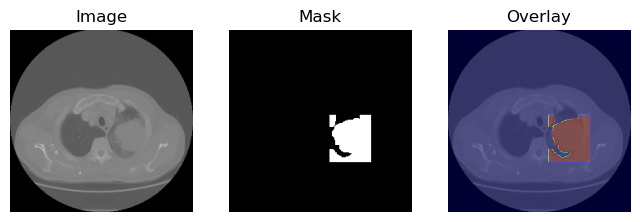

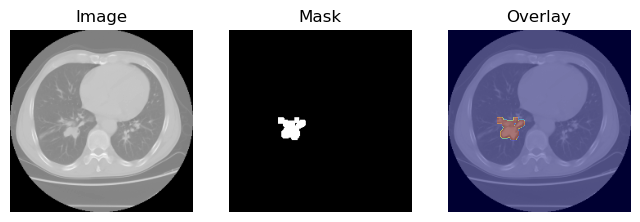

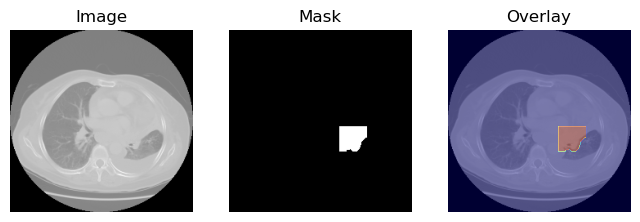

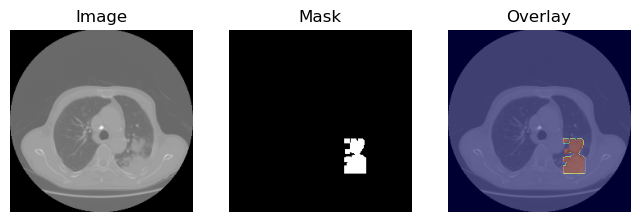

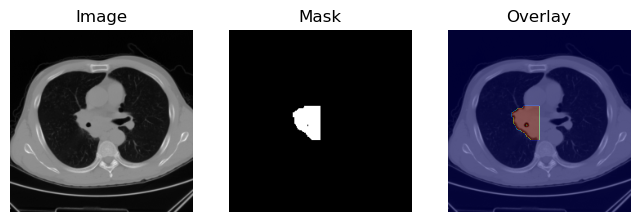

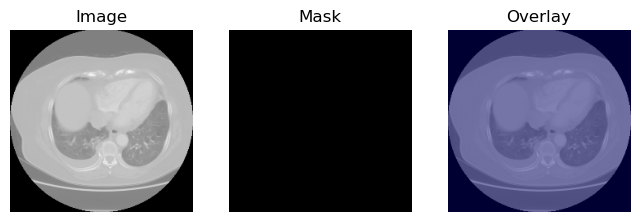

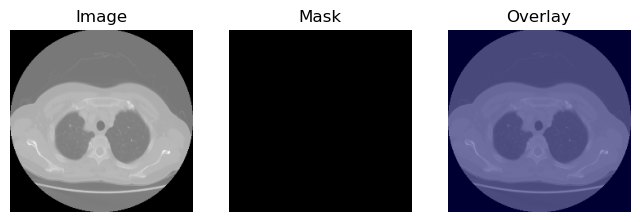

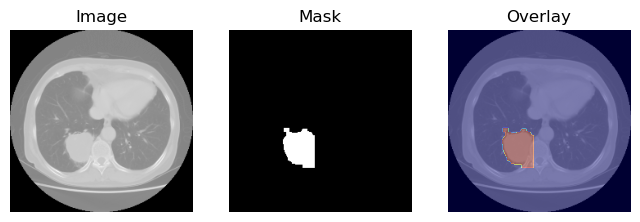

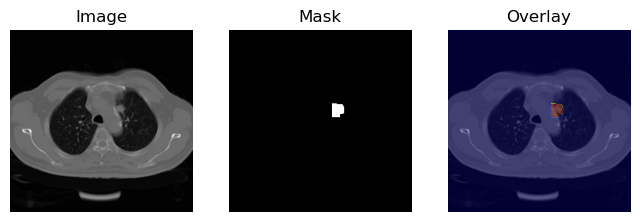

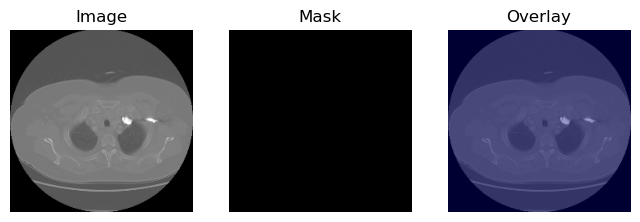

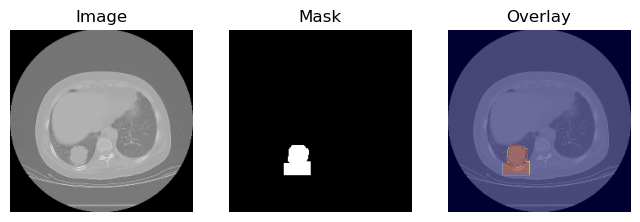

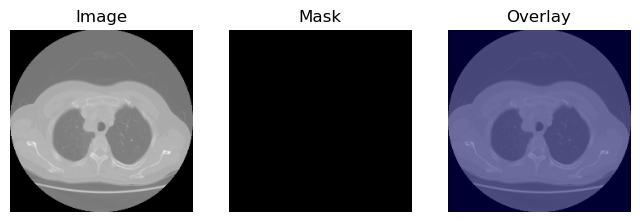

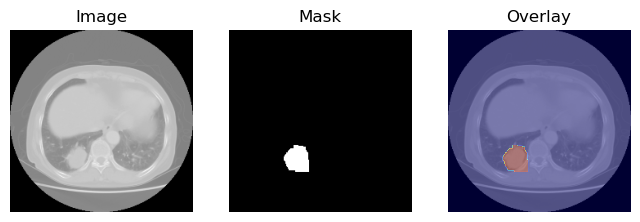

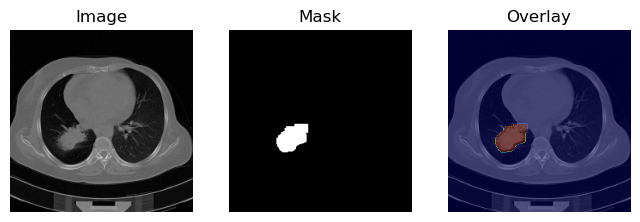

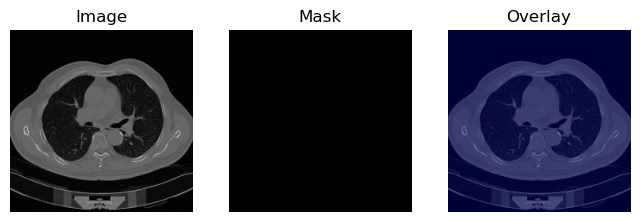

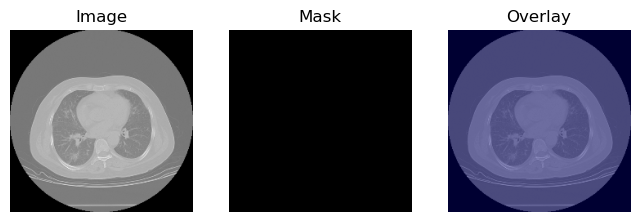

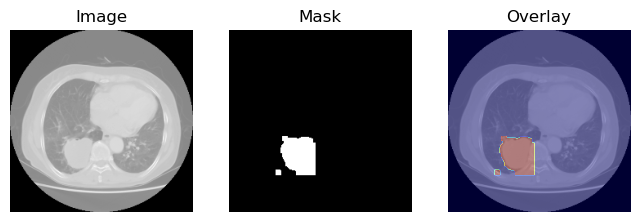

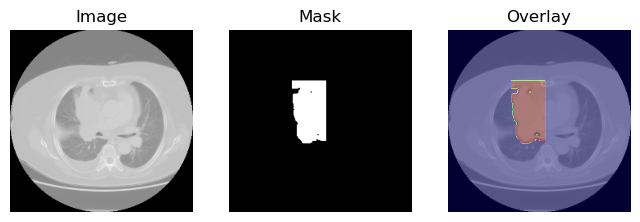

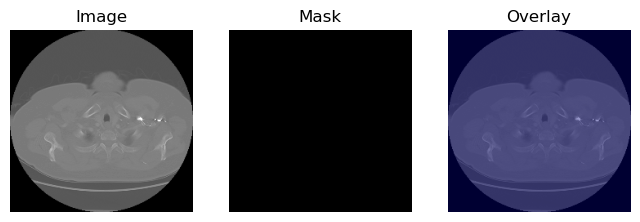

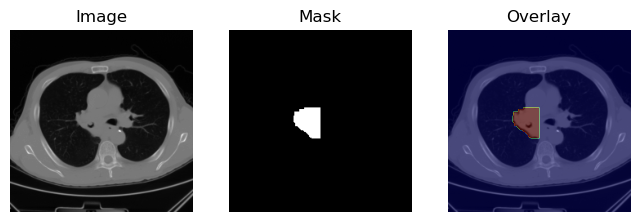

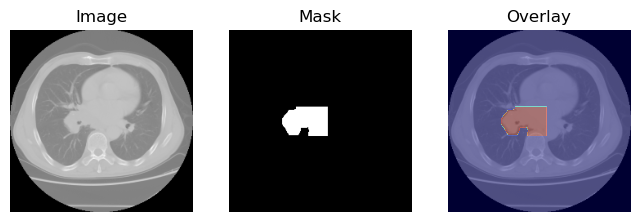

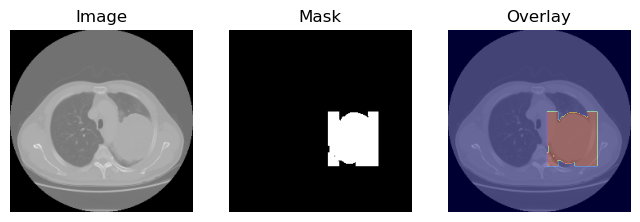

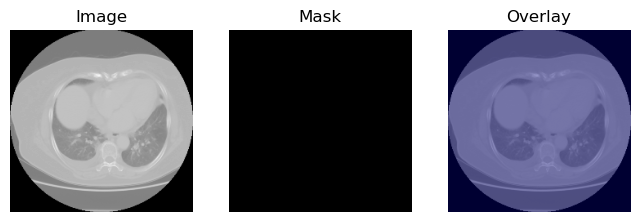

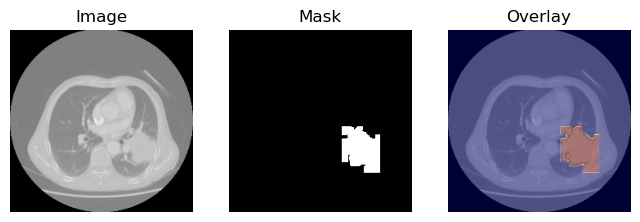

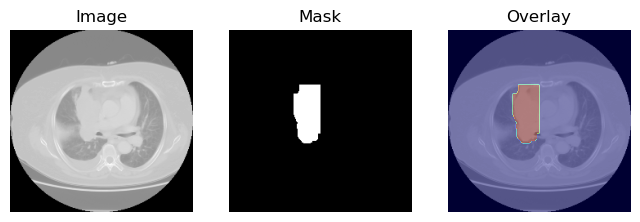

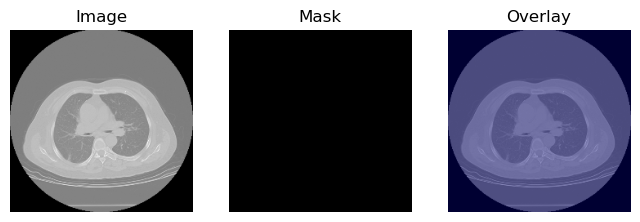

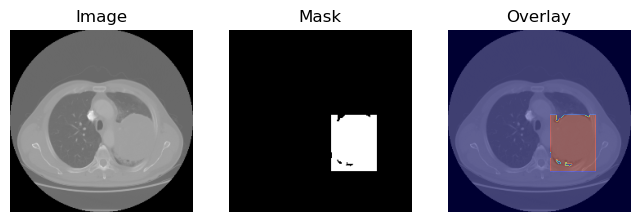

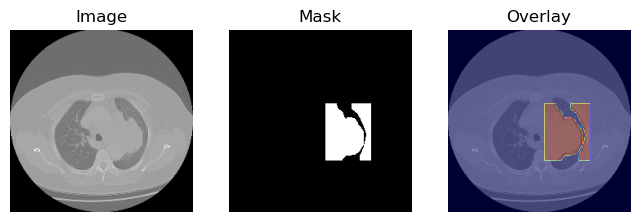

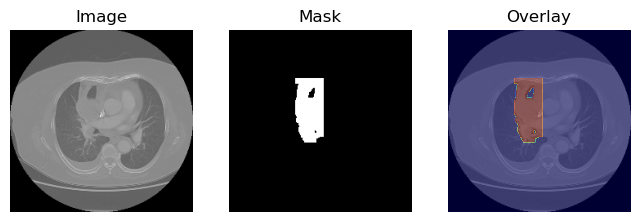

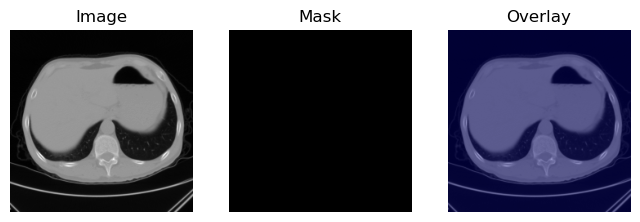

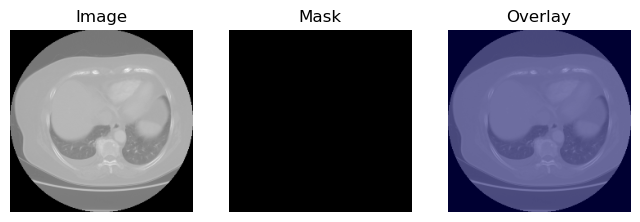

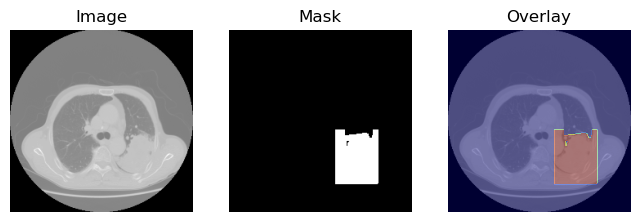

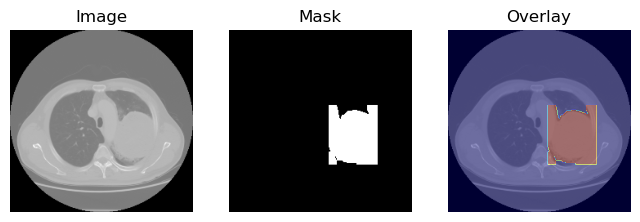

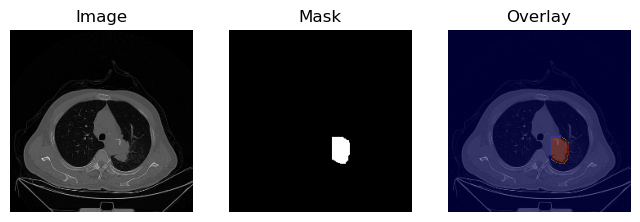

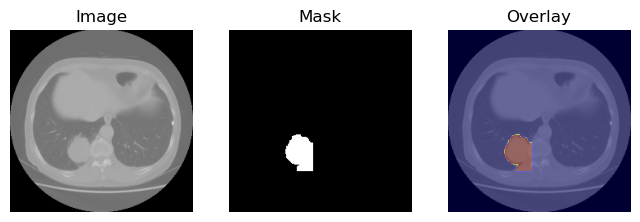

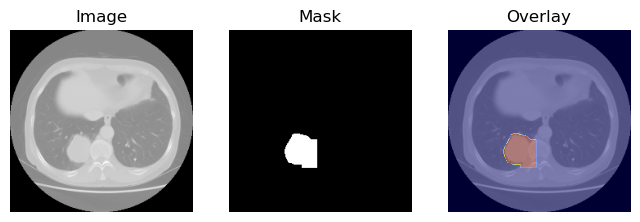

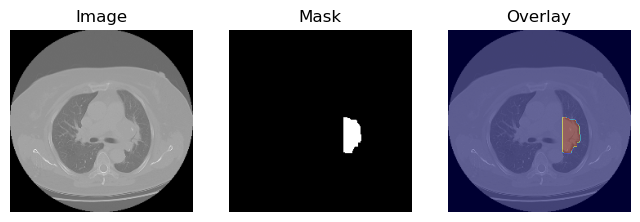

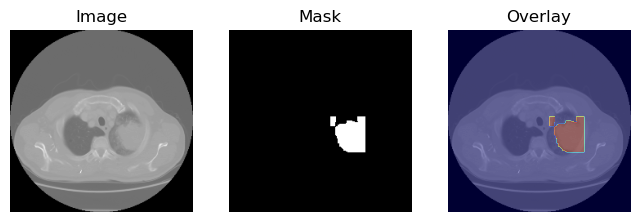

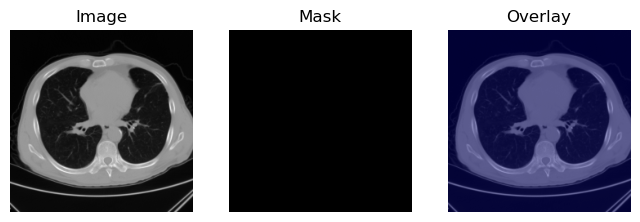

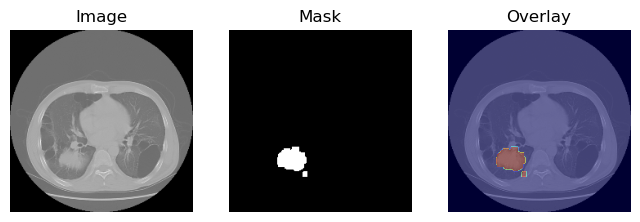

In [ ]:
   # 3) Optional: visualize a few samples before training
def visualize_samples(X, Y, n=50):
    idxs = np.random.choice(len(X), n, replace=False)
    for i in idxs:
        img = X[i]
        msk = Y[i].squeeze()
        plt.figure(figsize=(8,3))
        plt.subplot(1,3,1)
        plt.imshow(img[...,0], cmap="gray");  plt.title("Image"); plt.axis("off")
        plt.subplot(1,3,2)
        plt.imshow(msk, cmap="gray");        plt.title("Mask");  plt.axis("off")
        plt.subplot(1,3,3)
        plt.imshow(img[...,0], cmap="gray"); plt.imshow(msk, cmap="jet", alpha=0.4)
        plt.title("Overlay");              plt.axis("off")
        plt.show()
visualize_samples(X_train, Y_train, n=50)



In [ ]:
   # 6a) Stage 1: freeze encoder, train decoder at lr=1e-3
import tensorflow.keras.backend as K

for layer in seg_model.layers[:19]:
    layer.trainable = False
seg_model.compile(
    optimizer=SGD(learning_rate=1e-3, momentum=0.9),
    loss=combined_loss,
    metrics=["accuracy"]
)
print(">>> Stage 1: decoder-only training @ lr=1e-3")
history1 = seg_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=2
)
# 6b) Stage 2: unfreeze all, fine-tune full model at lr=1e-5
for layer in seg_model.layers:
    layer.trainable = True
seg_model.compile(
    optimizer=SGD(learning_rate=1e-5, momentum=0.9),
    loss=combined_loss,
    metrics=["accuracy"]
)
print(">>> Stage 2: full-model fine-tuning @ lr=1e-5")
history2 = seg_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=2
)
# 7) Evaluate & save
loss, acc = seg_model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}, Test Acc: {acc:.4f}")
seg_model.save(os.path.join(MODEL_DIR, "vgg19_segnet_balanced.keras"))
print("✅ Model saved to", MODEL_DIR)

>>> Stage 1: decoder-only training @ lr=1e-3
Epoch 1/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 1218s 2s/step - accuracy: 0.6649 - loss: 2.4609 - val_accuracy: 0.5001 - val_loss: 2.2994
Epoch 2/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 1168s 2s/step - accuracy: 0.7592 - loss: 1.8173 - val_accuracy: 0.8702 - val_loss: 1.3228
Epoch 3/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 1088s 2s/step - accuracy: 0.8879 - loss: 1.3305 - val_accuracy: 0.9607 - val_loss: 1.2686
Epoch 4/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 1088s 2s/step - accuracy: 0.9310 - loss: 1.1275 - val_accuracy: 0.9843 - val_loss: 1.0795
Epoch 5/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 1090s 2s/step - accuracy: 0.9527 - loss: 0.9521 - val_accuracy: 0.9555 - val_loss: 1.1788
Epoch 6/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 1052s 2s/step - accuracy: 0.9675 - loss: 0.8534 - val_accuracy: 0.9635 - val_loss: 0.8157
Epoch 7/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 1091s 2s/step - accuracy: 0.9748 - loss: 0.7599 - val_accuracy: 0.9895 - val_loss: 0.7739
Epoch 8/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 1087s

111/111 ━━━━━━━━━━━━━━━━━━━━ 64s 531ms/step
Avg. Dice  on test set: 0.9149
Avg. IoU   on test set: 0.8667


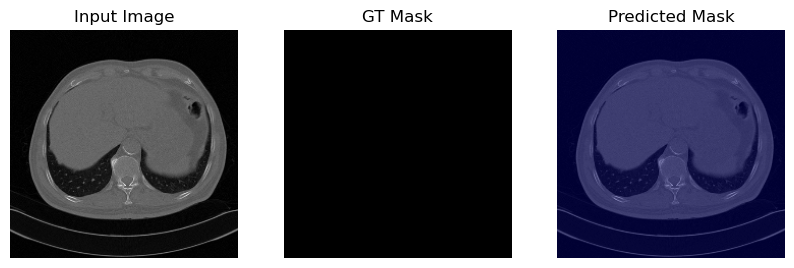

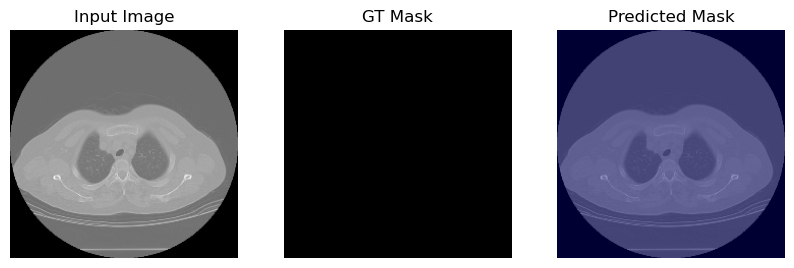

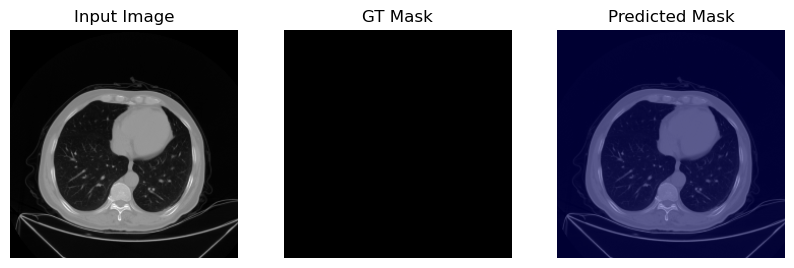

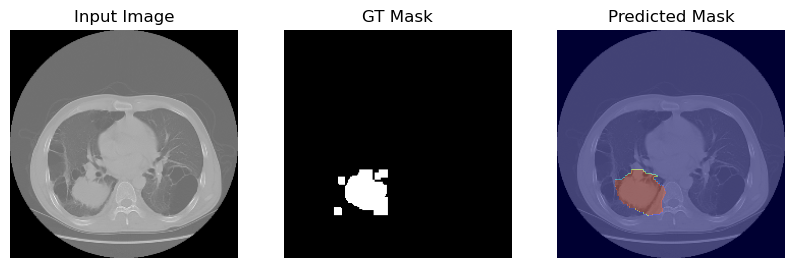

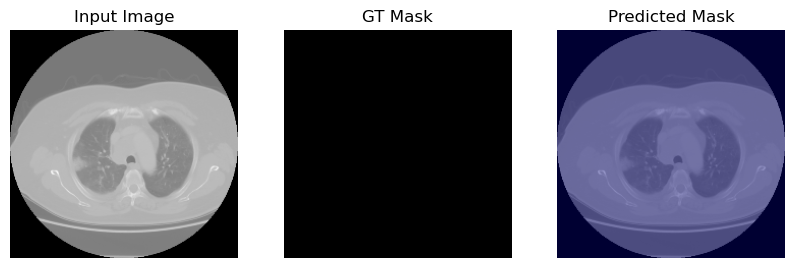

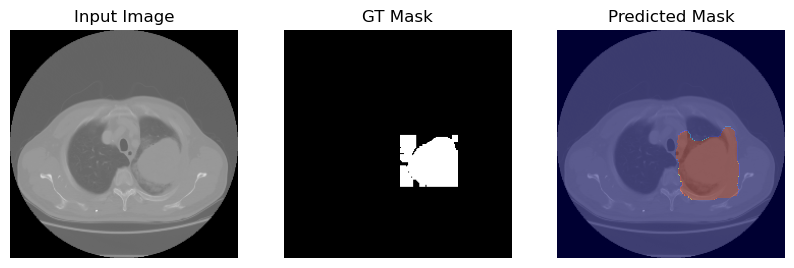

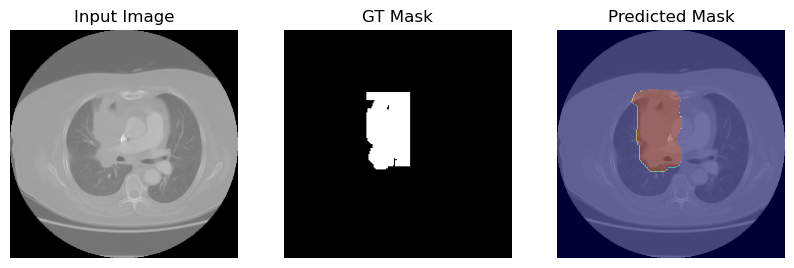

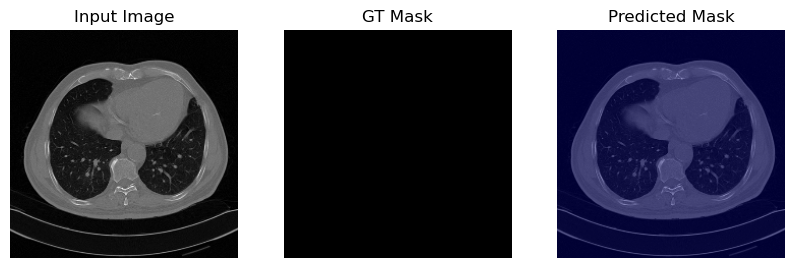

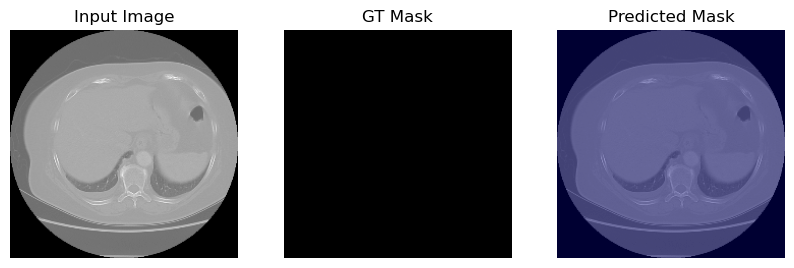

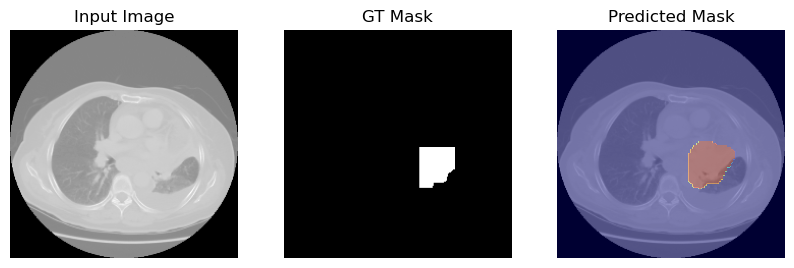

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2

# 1) Load your test data (assuming you've already got X_test, Y_test in memory
#    or you can re-call prepare_dataset and split)
# from segmentation import prepare_dataset, map_dicom_to_xml  # etc.

# e.g.
# X, Y = prepare_dataset(DICOM_DIR, XML_DIR, img_size=(224,224))
# _, X_test, _, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# 2) Load the saved model
model = load_model(os.path.join(MODEL_DIR, "vgg19_segnet_balanced.keras"), compile=False)
model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])

# 3) Predict on the test set
preds = model.predict(X_test, batch_size=2)             # shape (N,224,224,1)
preds_bin = (preds > 0.5).astype(np.uint8)

# 4) Define metrics
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter   = np.sum(y_true_f * y_pred_f)
    return (2*inter + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter   = np.sum(y_true_f * y_pred_f)
    union   = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

# 5) Compute average metrics over the test set
dices = [dice_coef(Y_test[i], preds_bin[i]) for i in range(len(Y_test))]
ious  = [iou_score (Y_test[i], preds_bin[i]) for i in range(len(Y_test))]
print(f"Avg. Dice  on test set: {np.mean(dices):.4f}")
print(f"Avg. IoU   on test set: {np.mean(ious) :.4f}")

# 6) Visualize a few examples
n_samples = 10
idxs = np.random.choice(len(X_test), n_samples, replace=False)
for i in idxs:
    img = X_test[i,...,0]        # grayscale background
    gt  = Y_test[i].squeeze()    # ground-truth mask
    pr  = preds_bin[i].squeeze() # predicted mask

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap="gray");     plt.title("Input Image");  plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(gt, cmap="gray");      plt.title("GT Mask");       plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img, cmap="gray");
    plt.imshow(pr, cmap="jet", alpha=0.4); plt.title("Predicted Mask"); plt.axis("off")
    plt.show()


In [ ]:
from tensorflow.keras.models import load_model, Model
import os

# Load full segmentation model
model_path = os.path.join(MODEL_DIR, "vgg19_segnet_balanced.keras")
model = load_model(model_path, compile=False)

# Identify bottleneck layer from model.summary() or by name
bottleneck_layer = "convnext_v2_base_block7_relu"  # Change if needed
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(bottleneck_layer).output)


In [ ]:
import numpy as np

def extract_features(X, model):
    feat_map = model.predict(X, batch_size=4)
    pooled = np.mean(feat_map, axis=(1, 2))  # Global average pooling
    return pooled

X_train_feat = extract_features(X_train, feature_extractor)
X_test_feat  = extract_features(X_test, feature_extractor)

# Binary class labels: 1 = nodule exists
y_train_cls = (Y_train.sum(axis=(1, 2, 3)) > 0).astype(int)
y_test_cls  = (Y_test.sum(axis=(1, 2, 3)) > 0).astype(int)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Optional: XGBoost if installed
try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    has_xgb = False

# All classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Linear SVM": LinearSVC(max_iter=1000),
    "RBF SVM": SVC(kernel="rbf", probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gaussian NB": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
}

if has_xgb:
    classifiers["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric="logloss")


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for name, clf in classifiers.items():
    print(f"\n🔍 Training: {name}")
    clf.fit(X_train_feat, y_train_cls)
    y_pred = clf.predict(X_test_feat)

    acc = accuracy_score(y_test_cls, y_pred)
    f1  = f1_score(y_test_cls, y_pred)
    print(f"✅ Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")
    print(classification_report(y_test_cls, y_pred, digits=4))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_cls, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-Nodule", "Nodule"], yticklabels=["Non-Nodule", "Nodule"])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [ ]:
import joblib
SAVE_DIR = os.path.join(MODEL_DIR, "classifiers_vgg19")
os.makedirs(SAVE_DIR, exist_ok=True)

for name, clf in classifiers.items():
    clf_path = os.path.join(SAVE_DIR, f"{name.replace(' ', '_')}.pkl")
    joblib.dump(clf, clf_path)
    print(f"💾 Saved: {clf_path}")
